# 1. Hierarchical Classification


In [1]:
from hiercls.utils.registry import registry
from hiercls.datasets.datasets import *
from hiercls.models.meta_archs import *
from hiercls.utils.losses import *
from hiercls.utils.train_utils import *
from hiercls.utils.metrics import *
from hiercls.utils.helper_utils import *
from hiercls.datasets.data_utils import *
from hiercls.datasets.dataloader import *

In [2]:
import torch
import yaml
from omegaconf import OmegaConf

In [3]:
# %load_ext autoreload
# %autoreload 2

##### 1. Reading the config file, and creating a dataset config, to get images

In [4]:
config_path = 'hiercls/config/config.yaml'

# In this config, we are testing leaf-level only with soft_labels

with open(config_path, "r") as infile:
    config = yaml.load(infile, Loader=yaml.loader.SafeLoader)

config = OmegaConf.create(config)
cfg = config

In [5]:
device = torch.device(cfg.device if torch.cuda.is_available() else "cpu")

dataset_name = cfg.dataset.name
dataset_config = cfg.dataset[dataset_name]
dataset_config.seed = cfg.seed
dataset_config.image_dimension = cfg.dataset.image_dimension
dataset_config.annot_dir = 'demo'

##### 2. Creating `hierarchy` and `hierarchy_int`, which contain paths to all leaves from top most level, for example, `hierarchy` is a list-of-lists,  `[['drinks', 'coffee', 'Blue_Tokai_coffee'], ...]` and `hierarchy_int` contains the same, but instead of class names, it contains the integer that is mapped to it. 

##### `hier_info` is a dict which contains information about the hierarchy of the dataset

In [6]:
hierarchy, hierarchy_int = registry.mappings["annotation_creation"][dataset_name](
    dataset_config
)

(num_levels, num_cls_in_level) = get_stats_of_hierarchy(hierarchy_int)
hierarchy_tree = get_nltk_tree_from_hierarchy(hierarchy_int)

In [7]:
print("\n\nNumber of levels in hierarchy:", num_levels)
print("Number of nodes in each level:", num_cls_in_level)

hier_info = {"num_levels":num_levels, 
            "num_cls_in_level":num_cls_in_level,
            "hierarchy":hierarchy,
            "hierarchy_int": hierarchy_int,
            "hierarchy_tree":hierarchy_tree,
            "dataset_config":dataset_config}



Number of levels in hierarchy: 3
Number of nodes in each level: [11, 51, 452]


In [8]:
# using the custom DotDict class, to convert a regular dict to 
# a dictionary, whose values can be accessed using a dot notation.

hier_info = DotDict(**hier_info)

##### 3. Creating the model based on the config, and loading the checkpoint 



In [9]:
model = registry.mappings["meta_archs"][cfg.model.meta_arch.name](
    cfg.model,
    hier_info
)
loss_config = cfg.loss_config[cfg.train.loss_class]
criterion = registry.mappings["losses"][cfg.train.loss_class](loss_config, hier_info)
criterion.to(device)


SoftLabelsLoss()

**Note:** make sure you have downloaded the correct checkpoint.

In [10]:
ckpt = torch.load('blip2_lo_SL.pth.tar')

In [11]:
model.load_state_dict(ckpt["model_state_dict"])
model.to(device)

CBackboneOneBranch(
  (backbone): BLIPv2(
    (model): Blip2Qformer(
      (visual_encoder): VisionTransformer(
        (patch_embed): PatchEmbed(
          (proj): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
        )
        (pos_drop): Dropout(p=0.0, inplace=False)
        (blocks): ModuleList(
          (0-38): 39 x Block(
            (norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
            (attn): Attention(
              (qkv): Linear(in_features=1408, out_features=4224, bias=False)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=1408, out_features=1408, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=1408, out_features=6144, bias=True)
              (act): GELU(approximate='none')
             

##### 4. Creating a dataset and a dataloader for the demo images

In [12]:
demo_dataset = registry.mappings["datasets"][cfg.dataset.name](
    dataset_config, "sample"
)


demo_dataloader = make_data_loader(
    dataset=demo_dataset,
    batch_size=2,
    num_workers=1
)


#### 5. Inference

In [13]:
import os

# Example path from your error
img_path = 'demo\\sample_images\\Hero_Splendor_25.jpg'
# Convert to Linux style
img_path_fixed = img_path.replace('\\', '/')
print("Fixed path:", img_path_fixed)
print("Exists?", os.path.exists(img_path_fixed))

Fixed path: demo/sample_images/Hero_Splendor_25.jpg
Exists? True


In [14]:
_, test_pred, test_gt, _ = test_one_epoch(
    test_dataloader = demo_dataloader,
    criterion = criterion,
    model = model,
    device = device,
    hierarchy_int = hierarchy_int,
    bet_on_leaf_level = cfg.test.bet_on_leaf_level,
    loss_class = cfg.train.loss_class
)

TEST EPOCH


  0%|          | 0/18 [00:00<?, ?it/s]

Image path: demo/sample_images/Zomato_1.jpg
Trying to read image: demo/sample_images/Zomato_1.jpg
Image path: demo/sample_images/Indigo_10.jpg
Trying to read image: demo/sample_images/Indigo_10.jpg
Image path: demo/sample_images/Apple_laptops_and_computers_19.jpg
Trying to read image: demo/sample_images/Apple_laptops_and_computers_19.jpg
Image path: demo/sample_images/Sonata_watches_31.jpg
Trying to read image: demo/sample_images/Sonata_watches_31.jpg
Image path: demo/sample_images/Hero_Splendor_25.jpg
Trying to read image: demo/sample_images/Hero_Splendor_25.jpg
Image path: demo/sample_images/Skoda_Kushaq_29.jpg
Trying to read image: demo/sample_images/Skoda_Kushaq_29.jpg


  6%|▌         | 1/18 [00:26<07:32, 26.63s/it]

Image path: demo/sample_images/Indigo_24.jpg
Trying to read image: demo/sample_images/Indigo_24.jpg
Image path: demo/sample_images/Harpic_toilet_cleaner_27.jpg
Trying to read image: demo/sample_images/Harpic_toilet_cleaner_27.jpg


 11%|█         | 2/18 [00:57<07:49, 29.36s/it]

Image path: demo/sample_images/State_Bank_Of_India_44.jpg
Trying to read image: demo/sample_images/State_Bank_Of_India_44.jpg
Image path: demo/sample_images/Clinic_Plus_shampoo_27.jpg
Trying to read image: demo/sample_images/Clinic_Plus_shampoo_27.jpg


 17%|█▋        | 3/18 [01:19<06:26, 25.79s/it]

Image path: demo/sample_images/Clinic_Plus_shampoo_28.jpg
Trying to read image: demo/sample_images/Clinic_Plus_shampoo_28.jpg
Image path: demo/sample_images/Hero_Passion_Pro_3.jpg
Trying to read image: demo/sample_images/Hero_Passion_Pro_3.jpg


 22%|██▏       | 4/18 [01:36<05:11, 22.26s/it]

Image path: demo/sample_images/Ariel_detergent_9.jpg
Trying to read image: demo/sample_images/Ariel_detergent_9.jpg
Image path: demo/sample_images/Adidas_37.jpg
Trying to read image: demo/sample_images/Adidas_37.jpg


 28%|██▊       | 5/18 [01:54<04:32, 20.97s/it]

Image path: demo/sample_images/Bingo_wafers_18.jpg
Trying to read image: demo/sample_images/Bingo_wafers_18.jpg
Image path: demo/sample_images/State_Bank_Of_India_29.jpg
Trying to read image: demo/sample_images/State_Bank_Of_India_29.jpg


 33%|███▎      | 6/18 [02:13<04:02, 20.18s/it]

Image path: demo/sample_images/Zomato_22.jpg
Trying to read image: demo/sample_images/Zomato_22.jpg
Image path: demo/sample_images/Sonata_watches_21.jpg
Trying to read image: demo/sample_images/Sonata_watches_21.jpg


 39%|███▉      | 7/18 [02:31<03:34, 19.52s/it]

Image path: demo/sample_images/Huggies_diapers_and_wipes_26.jpg
Trying to read image: demo/sample_images/Huggies_diapers_and_wipes_26.jpg
Image path: demo/sample_images/Enerzal_31.jpg
Trying to read image: demo/sample_images/Enerzal_31.jpg


 44%|████▍     | 8/18 [02:50<03:12, 19.25s/it]

Image path: demo/sample_images/MRF_tyres_19.jpg
Trying to read image: demo/sample_images/MRF_tyres_19.jpg
Image path: demo/sample_images/Adidas_31.jpg
Trying to read image: demo/sample_images/Adidas_31.jpg


 50%|█████     | 9/18 [03:10<02:54, 19.37s/it]

Image path: demo/sample_images/Skoda_Octavia_6.jpg
Trying to read image: demo/sample_images/Skoda_Octavia_6.jpg
Image path: demo/sample_images/Apple_laptops_and_computers_24.jpg
Trying to read image: demo/sample_images/Apple_laptops_and_computers_24.jpg


 56%|█████▌    | 10/18 [03:29<02:35, 19.45s/it]

Image path: demo/sample_images/Biba_6.jpg
Trying to read image: demo/sample_images/Biba_6.jpg
Image path: demo/sample_images/Domex_floor_and_toilet_cleaner_3.jpg
Trying to read image: demo/sample_images/Domex_floor_and_toilet_cleaner_3.jpg


 61%|██████    | 11/18 [03:47<02:12, 18.94s/it]

Image path: demo/sample_images/Huggies_diapers_and_wipes_2.jpg
Trying to read image: demo/sample_images/Huggies_diapers_and_wipes_2.jpg
Image path: demo/sample_images/State_Bank_Of_India_24.jpg
Trying to read image: demo/sample_images/State_Bank_Of_India_24.jpg


 67%|██████▋   | 12/18 [04:05<01:52, 18.68s/it]

Image path: demo/sample_images/Enerzal_38.jpg
Trying to read image: demo/sample_images/Enerzal_38.jpg
Image path: demo/sample_images/MRF_tyres_17.jpg
Trying to read image: demo/sample_images/MRF_tyres_17.jpg


 72%|███████▏  | 13/18 [04:23<01:32, 18.43s/it]

Image path: demo/sample_images/Happilo_18.jpg
Trying to read image: demo/sample_images/Happilo_18.jpg
Image path: demo/sample_images/Biba_8.jpg
Trying to read image: demo/sample_images/Biba_8.jpg


 78%|███████▊  | 14/18 [04:41<01:13, 18.45s/it]

Image path: demo/sample_images/Happilo_4.jpg
Trying to read image: demo/sample_images/Happilo_4.jpg
Image path: demo/sample_images/Ariel_detergent_34.jpg
Trying to read image: demo/sample_images/Ariel_detergent_34.jpg


 83%|████████▎ | 15/18 [05:00<00:55, 18.53s/it]

Image path: demo/sample_images/Bingo_wafers_1.jpg
Trying to read image: demo/sample_images/Bingo_wafers_1.jpg


100%|██████████| 18/18 [05:41<00:00, 18.96s/it]


In [15]:
print("TEST PRED:", test_pred[:5], "\n TEST GT:", test_gt[:5])

TEST PRED: [[231], [178], [329], [239], [201]] 
 TEST GT: [[6, 14, 436], [9, 1, 180], [4, 11, 15], [1, 49, 376], [10, 46, 442]]


In [16]:
# The predictions and ground truth are always sent as list of lists
predictions = [x[-1] for x in test_pred]
ground_truth = [x[-1] for x in test_gt]

In [15]:
from glob import glob
import pickle 

int_to_str_class_mapping = glob('demo/level_*_int_to_str.pkl')
level_wise_mapping = []
for path in int_to_str_class_mapping:
    with open(path, 'rb') as infile:
        mapping_dict = pickle.load(infile)
    level_wise_mapping.append(mapping_dict)

In [16]:
import matplotlib.pyplot as plt

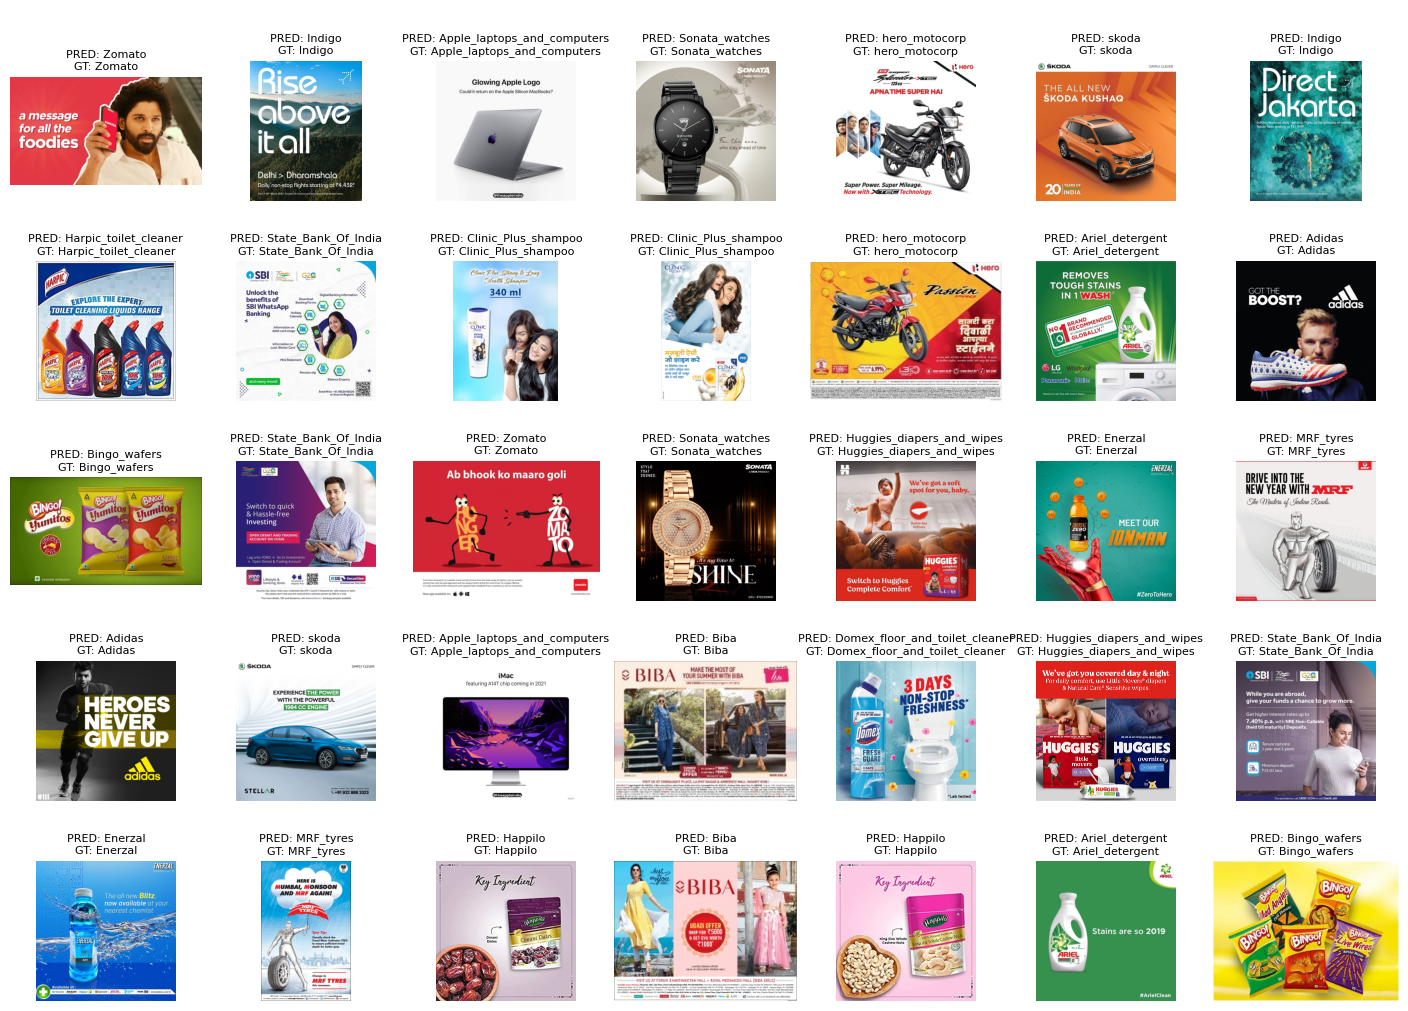

In [18]:
fig, axes = plt.subplots(5,7,figsize=(14,10), constrained_layout=True)
img_path_and_annot = demo_dataset.images_and_hier_labels

for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    ax.imshow(cv2.cvtColor(cv2.imread(img_path_and_annot[i][0]), cv2.COLOR_BGR2RGB))
    pred = level_wise_mapping[2][predictions[i]]
    gt = level_wise_mapping[2][ground_truth[i]]
    ax.set_title(f"\n\nPRED: {pred}\nGT: {gt}",fontsize=8)



# 2. Ads Non-Ads Classification

In [1]:
from ads_non_ads_classifier.classification.models import *
from ads_non_ads_classifier.classification.utils import load_config
import torch
import random
from tqdm import tqdm
from transformers import ViTFeatureExtractor, ConvNextFeatureExtractor
from torch.utils.data import Dataset, DataLoader
from glob import glob
import cv2
import pickle
import shutil
import os
random.seed(42)


2024-04-10 14:40:32.711696: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 14:40:34.094694: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/user/anaconda3/envs/ads/lib/python3.10/site-packages/cv2/../../lib64:
2024-04-10 14:40:34.095028: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/user/anaconda3/envs/ads/lib/python3.10/site-pack

In [2]:
# Defining dataset class
class AdsNonAds(Dataset):
    def __init__(self,
                 images_dir,
                 img_preprocessor):

        assert os.path.exists(
            images_dir), "The path {} does not exist".format(images_dir)

        self.data_dirs = images_dir

        self.dataset = self.train_dataset()

        self.image_transforms = img_preprocessor

    def train_dataset(self):
        data = glob(os.path.join(self.data_dirs, '**/*.*'), recursive=True)
        random.shuffle(data)
        return data


    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        filename = self.dataset[idx]

        # The shape of the image is (height, width, channels)
        # any image is read as BGR image --> converted to RGB
        image = cv2.imread(
            filename,
            flags=cv2.IMREAD_COLOR)

        # If images is empty for some I/O reasons
        if image is None: 
            return (torch.zeros(3,224,224), self.dataset[idx])

        image = cv2.cvtColor(image,
            code=cv2.COLOR_BGR2RGB)
        transformed_image = self.image_transforms(image, return_tensors="pt")[
            "pixel_values"].squeeze(0)  # 3, H, W
        return (transformed_image, self.dataset[idx])

# Defining collate function
def collate_function(batch):

    inputs = torch.stack([x[0] for x in batch])
    filenames = [x[1] for x in batch]

    # (batch_size, channels, h, w),  (batch_size)
    return (inputs, filenames)

# Defining dataloader
def make_data_loader(dataset,
                     batch_size,
                     num_workers,
                     sampler=None):

    return DataLoader(dataset,
                      batch_size=batch_size,
                      collate_fn=collate_function,
                      num_workers=num_workers,
                      persistent_workers=True,
                      sampler=sampler)



In [3]:

# loading the config file
config_file_path ='./ads_non_ads_classifier/classification/config.yaml'
config = load_config(config_file_path)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Give path to the unannotated image folder
dataset_folder = 'test_images'
# Give path to the model checkpoint 
ckpt_path = './ad_classifier_model/best_combined.pth.tar'



In [4]:

# The below variable tells what should be used as the feature extractor,
# like vit, or convnext etc. It is specified in config file.
feat_ext_name = config['model']['feat_extractor']
feat_ext_config = config['arch'][feat_ext_name]


# Image preprocessor is sent to AdsNonAds dataset, which will preprocess the input the same way it
# was done for the images during pretraining of that model.

# NOTE: <something>FeatureExtractor == used for preprocessing purposes.
# IT WILL NOT RETURN feature vector of an image
img_preprocessor = None

if feat_ext_name == 'vit':
    img_preprocessor = ViTFeatureExtractor.from_pretrained(
        feat_ext_config['args']['pretrained'])
else:
    img_preprocessor = ConvNextFeatureExtractor.from_pretrained(
        feat_ext_config['args']['pretrained'])

dataset = AdsNonAds(images_dir=dataset_folder,
                    img_preprocessor=img_preprocessor)

dataloader = make_data_loader(dataset=dataset,
                              batch_size=config['model']['batch_size'],
                              num_workers=4,
                              sampler=None)

# We will use model_name_to_class, which is a dictionary that maps name
# of the model, from str to class, to initialize the desired model.

model = model_name_to_class[feat_ext_config['class']](
    pretrained=feat_ext_config['args']['pretrained'],
    feature_dim=feat_ext_config['args']['feature_dim'],
    num_classes=feat_ext_config['args']['num_classes'],
    dropout_prob=feat_ext_config['args']['dropout_prob'],
    is_trainable=feat_ext_config['args']['is_trainable']
)

ckpt = torch.load(ckpt_path)
model.load_state_dict(ckpt["model_state_dict"])
print("\nModel is loaded with the checkpoint")
model.to(device)

filenames = []
predictions = []

with torch.no_grad():
    model.eval()
    for batch in tqdm(dataloader):
        inputs, img_filenames = batch
        inputs = inputs.to(device)

        output = model(inputs)
        temp=output.argmax(dim=1).tolist()
            
        predictions.extend(temp)
        filenames.extend(img_filenames)

print(len(filenames),len(predictions))


/home/user/anaconda3/envs/ads/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(



Model is loaded with the checkpoint


  0%|          | 0/1 [00:00<?, ?it/s]libpng error: bad parameters to zlib
libpng error: bad parameters to zlib
libpng error: bad parameters to zlib
libpng error: bad parameters to zlib
100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

14 14


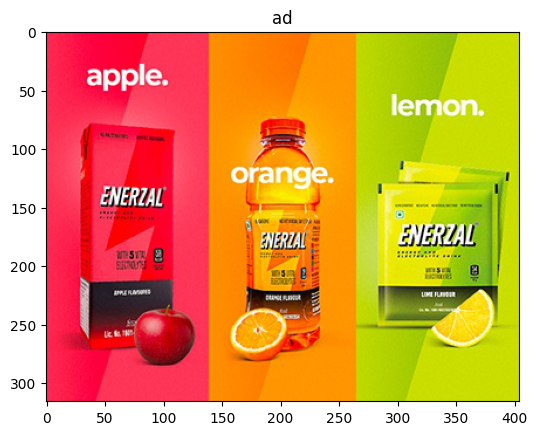

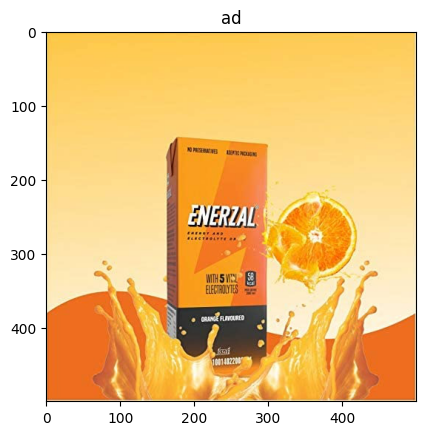

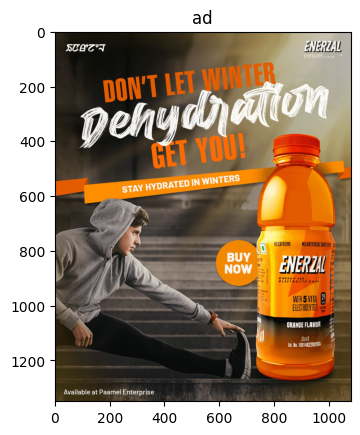

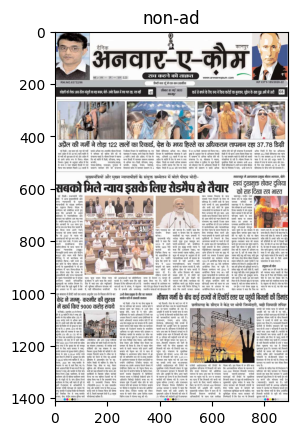

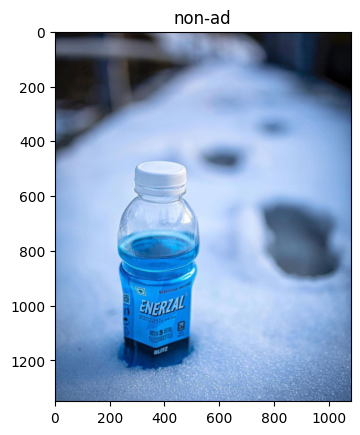

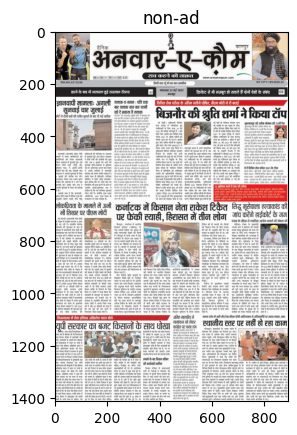

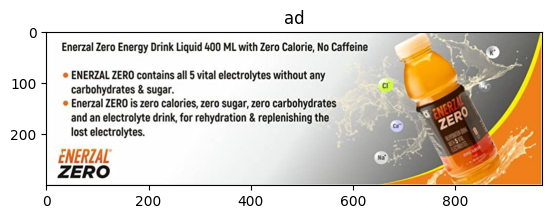

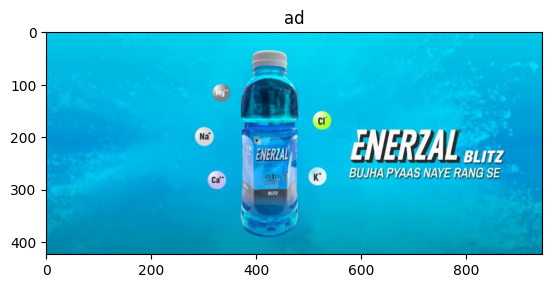

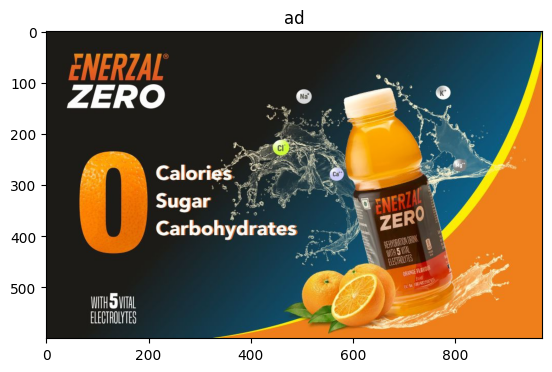

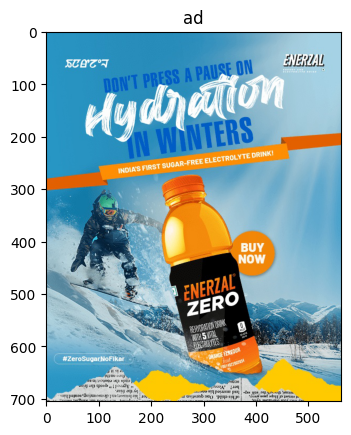

In [5]:
# Displaying the images and their predictions
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for i in range(10):
    img = mpimg.imread(filenames[i])
    plt.imshow(img)
    plt.title('ad' if predictions[i]== 1 else 'non-ad')
    plt.show()

# 3. Source Classification

In [6]:

class AdSource(Dataset):
    def __init__(self,
                 images_dir,
                 img_preprocessor):

        assert os.path.exists(
            images_dir), "The path {} does not exist".format(images_dir)

        self.data_dirs = images_dir

        self.dataset = self.train_dataset()

        self.image_transforms = img_preprocessor

    def train_dataset(self):
        data = glob(os.path.join(self.data_dirs, '**/*.*'), recursive=True)
        random.shuffle(data)
        return data


    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        filename = self.dataset[idx]

        # The shape of the image is (height, width, channels)
        # any image is read as BGR image --> converted to RGB
        image = cv2.imread(
            filename,
            flags=cv2.IMREAD_COLOR)

        # If images is empty for some I/O reasons
        if image is None: 
            return (torch.zeros(3,224,224), self.dataset[idx])

        image = cv2.cvtColor(image,
            code=cv2.COLOR_BGR2RGB)
        transformed_image = self.image_transforms(image, return_tensors="pt")[
            "pixel_values"].squeeze(0)  # 3, H, W
        return (transformed_image, self.dataset[idx])


In [9]:
# Give path corresponding to which n-class classification you want
# loading the config file
config_file_path ='./ad_source_prediction/two_class_classification/config.yaml'
config = load_config(config_file_path)
two_class_ckpt_path = '../experiments/ad_source/two_class/checkpoints/vit_best.pth.tar'
three_class_ckpt_path = '../experiments/ad_source/three_class/checkpoints/vit_best.pth.tar'


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Give path to the unannotated image folder
dataset_folder = 'test_images'
# Give path to the model checkpoint

In [10]:
# The below variable tells what should be used as the feature extractor,
# like vit, or convnext etc. It is specified in config file.
feat_ext_name = config['model']['feat_extractor']
feat_ext_config = config['arch'][feat_ext_name]


# Image preprocessor is sent to AdsNonAds dataset, which will preprocess the input the same way it
# was done for the images during pretraining of that model.

# NOTE: <something>FeatureExtractor == used for preprocessing purposes.
# IT WILL NOT RETURN feature vector of an image
img_preprocessor = None

if feat_ext_name == 'vit':
    img_preprocessor = ViTFeatureExtractor.from_pretrained(
        feat_ext_config['args']['pretrained'])
else:
    img_preprocessor = ConvNextFeatureExtractor.from_pretrained(
        feat_ext_config['args']['pretrained'])

dataset = AdsNonAds(images_dir=dataset_folder,
                    img_preprocessor=img_preprocessor)

dataloader = make_data_loader(dataset=dataset,
                              batch_size=config['model']['batch_size'],
                              num_workers=4,
                              sampler=None)

# We will use model_name_to_class, which is a dictionary that maps name
# of the model, from str to class, to initialize the desired model.

model = model_name_to_class[feat_ext_config['class']](
    pretrained=feat_ext_config['args']['pretrained'],
    feature_dim=feat_ext_config['args']['feature_dim'],
    num_classes=feat_ext_config['args']['num_classes'],
    dropout_prob=feat_ext_config['args']['dropout_prob'],
    is_trainable=feat_ext_config['args']['is_trainable']
)
# Change here the ckpt path
ckpt = torch.load(two_class_ckpt_path)
model.load_state_dict(ckpt["model_state_dict"])
print("\nModel is loaded with the checkpoint")
model.to(device)

filenames = []
predictions = []

with torch.no_grad():
    model.eval()
    for batch in tqdm(dataloader):
        inputs, img_filenames = batch
        inputs = inputs.to(device)

        output = model(inputs)
        temp=output.argmax(dim=1).tolist()
            
        predictions.extend(temp)
        filenames.extend(img_filenames)

print(len(filenames),len(predictions))


Model is loaded with the checkpoint


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

15 15


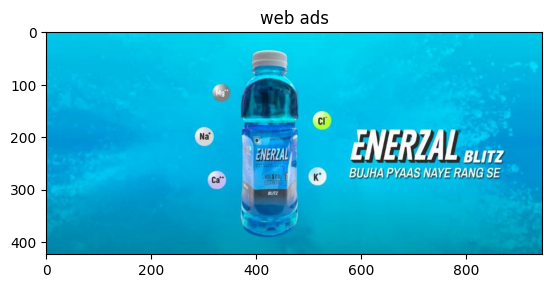

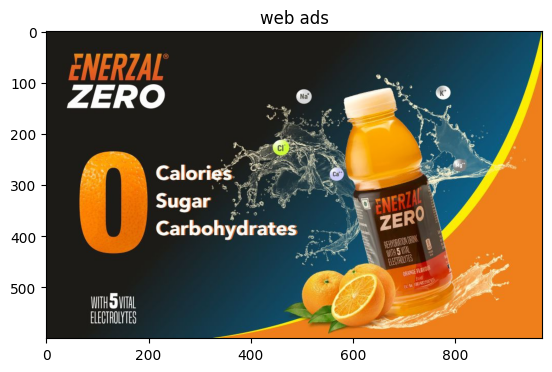

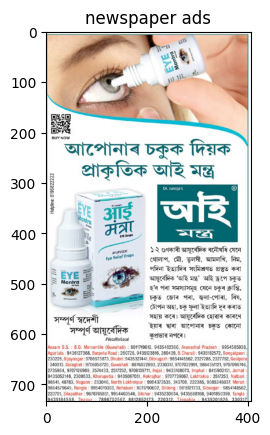

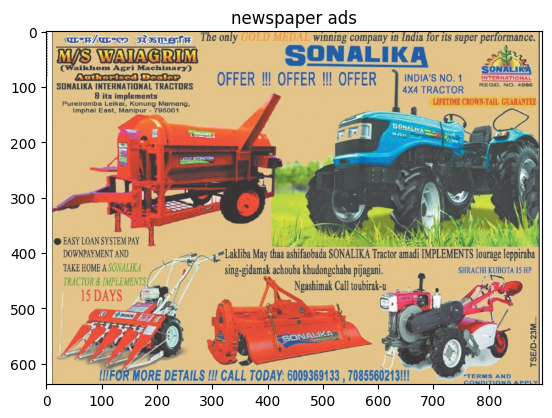

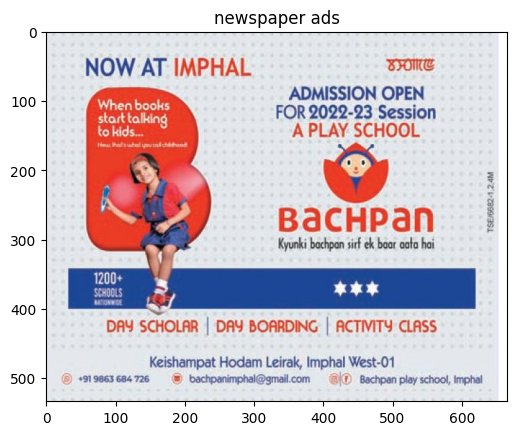

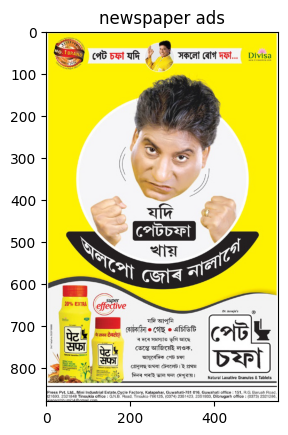

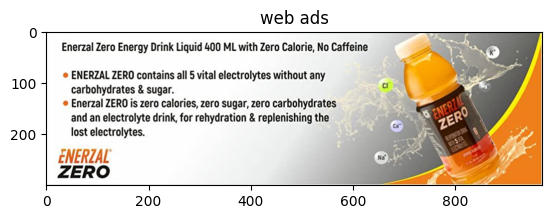

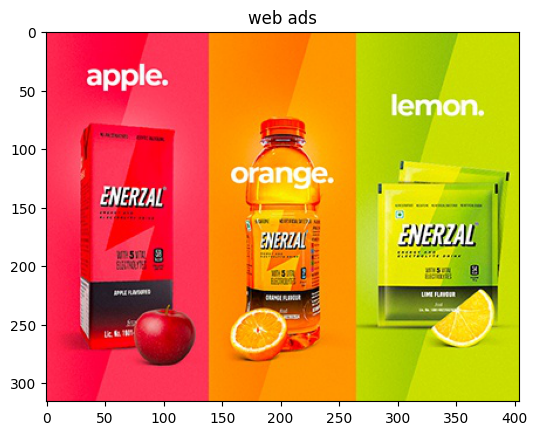

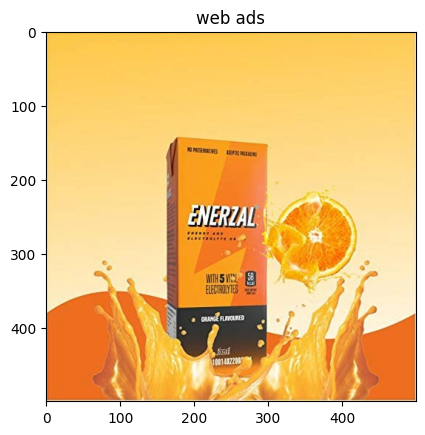

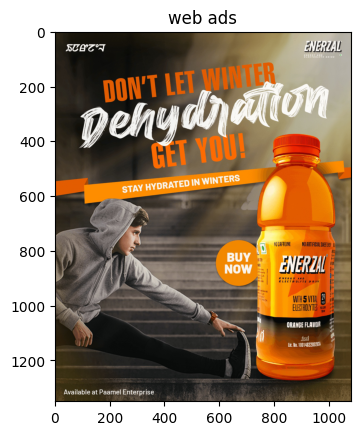

In [11]:
# Displaying the images and their predictions
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for i in range(10):
    img = mpimg.imread(filenames[i])
    plt.imshow(img)
    plt.title('web ads' if predictions[i]== 1 else 'newspaper ads')
    plt.show()